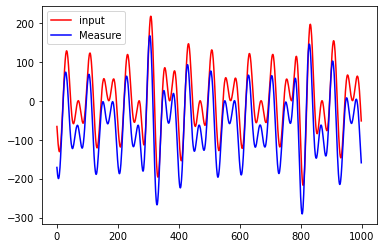

In [79]:
import matplotlib.pyplot as plt
import numpy as np

def read_data(file_name):
    """Reads the file and extracts the data columns"""
    # time, measure; input, record
    data = np.loadtxt(file_name)
    time_data = data[:, 0]
    input_data = data[:, 1]
    return time_data, input_data

def plot_input_data(input_data):
    """Plots the input data"""
    plt.figure()
    plt.plot(input_data, linewidth=2, color='red', label='Input Data')
    plt.title('Input Data')
    plt.ylabel('Voltage (V)')
    plt.legend(loc='lower right')
    plt.show()

def plot_measure_data(measure_data):
    """Plots the measured data"""
    plt.figure()
    plt.style.use('seaborn-whitegrid')
    plt.plot(measure_data, linewidth=2, color='blue', label='Measured Data')
    plt.title('Measured Data')
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (V)')
    plt.legend(loc='lower right')
    plt.show()

# Define the file name containing Chinese characters
file_name = u'../data/20230808/145C-noisy-unkonwn-data-5min'

time_delay = 8 # ms

# Read the data
measure_data, input_data = read_data(file_name)

start_num = 1005
measure_num = start_num + 1000

cropped_measure_data = measure_data[(start_num+time_delay):(measure_num+time_delay)]
cropped_input_data = input_data[start_num:measure_num]
b_input = cropped_input_data * 1000 # V --> mV --> pT , mV
y_measure = cropped_measure_data * 1000 # V --> mV
y_measure_current = measure_data[start_num:measure_num] * 1000

# Plot the input data
# plot_input_data(cropped_input_data[:100])
# plot_input_data(cropped_time_data[:100])
# Plot the measured data
#plot_measure_data(cropped_time_data)
plt.plot(7.45818*b_input, color='red', label='input')
plt.plot(y_measure, color='blue', label='Measure')
plt.legend()

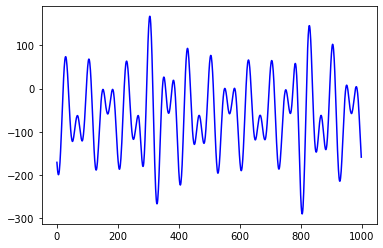

In [80]:
plt.plot(y_measure, color='blue', label='Measure')

In [81]:
# 添加了0.1mV的白噪声，2.742mVrms （0.1mV noise） -- > 10.82 mVrms
0.1 * 10.82/2.742

0.39460247994164843

In [82]:
import numpy as np
import matplotlib.pyplot as plt
xTime = np.array([1/1000 * i for i in range(y_measure_current.shape[0])])
xData = b_input
# Add white noise with amplitude 0.1
range_1 = 0.3946;  # Range of the white noise
variance = (range_1**2) / 12;

#noise_amplitude = variance


#noise = noise_amplitude * np.random.normal(0, 1, len(xData))
xData_with_noise = b_input

yData = y_measure


In [83]:
variance 

0.012975763333333334

In [84]:
import numpy as np
6.3246 * np.sqrt(2)

8.944335096584878

In [85]:
from filterpy.kalman import KalmanFilter
#noise_us = noise_amplitude * np.random.normal(0, 1, len(xData))
dt = 1/1000   # time step 1 second

zRef = 7.45818 * b_input
Kscale = 7.45818

#zPred = np.asarray(zPred).reshape(-1)
# zRef = yData
# Kscale = 7.45818
# Plot the predicted and reference curves
#timeRange = np.array([1/1000 * i for i in range(len(BInput))])
timeRange = xTime
coil_constant = 9.2393 #pT/mV
Qspn = 1.8824 # fT
Q1 = 0
#Q2 = 9.2845*1e-5
Q2 = Qspn / coil_constant * 1e-3 * Kscale / 100   # uA

## dynamic noise
noise_amplitude = 0.012975
#noise_amplitude = 10
Qdynamic = noise_amplitude**2/dt**3
#inputNoise = np.random.randn(len(timeRange)) * np.sqrt(Qdynamic)


#Q2 = 11.2845*1e-5

#GRpsn = 6.3246*1e-4
#GRpsn = 8.9443 * 1e-4
GRpsn = 2.9306654534422725e-05 * 100 # mV
#GRpsn = 0.0286

tracker = KalmanFilter(dim_x=4, dim_z=1)


tracker.F = np.array([[1, dt,0,0],[0,1,dt,0],[0,0,1,0],[Kscale / 100, 0,0,0]])

from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise

#q = Q_discrete_white_noise(dim=2, dt=dt, var=0.01)
tracker.Q = np.array([[0, 0,0,0],[0, 0,0,0],[0, 0,Qdynamic,0],[0, 0,0,Q2**2]])
print(tracker.Q)
#tracker.B = np.array([[0],[0],[0],[0]])

tracker.H = np.array([[0, 0,0, 1e1]])

tracker.R = np.array([[GRpsn**2]])

tracker.x = np.array([[0],[0],[0],[0]])
tracker.P = np.eye(4) * 1.
#tracker.P = 1
mu, cov, _, _ = tracker.batch_filter(yData)

mu0 = mu[:,0,:].reshape(-1)
mu_2sd = mu[:,2,:].reshape(-1)
mu_1sd = mu[:,1,:].reshape(-1)
mu1 = mu[:,3,:].reshape(-1)
KF_estimate_In = mu0 
KF_estimate_Measure = mu1 * 1e2

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.68350625e+05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.30893343e-10]]


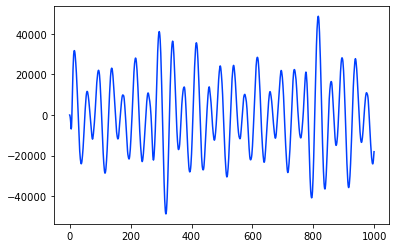

In [86]:
plt.plot(mu_1sd)

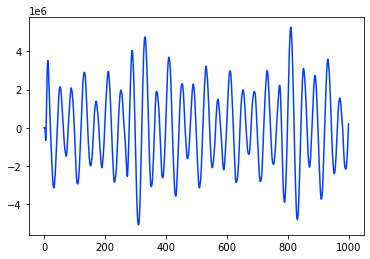

In [87]:
plt.plot(mu_2sd)

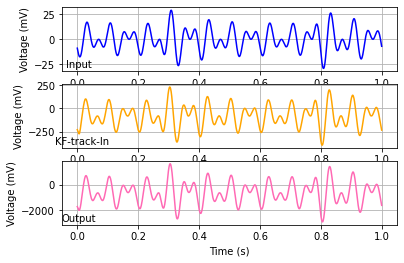

In [88]:
plt.style.use('seaborn-bright')

plt.subplot(3, 1, 1)
plt.plot(timeRange, xData_with_noise, color='blue')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.text(0.05, 0.1, 'Input', transform=plt.gca().transAxes, ha='center', va='center')

plt.subplot(3, 1, 2)
plt.plot(timeRange, KF_estimate_In, color='orange')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.text(0.06, 0.1, 'KF-track-In', transform=plt.gca().transAxes, ha='center', va='center')

plt.subplot(3, 1, 3)
plt.plot(timeRange, KF_estimate_Measure, color='#FF69B4')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.grid(True)
plt.text(0.05, 0.1, 'Output', transform=plt.gca().transAxes, ha='center', va='center')

plt.savefig('KF_Tri_30Hz.png', dpi=300, bbox_inches='tight')


Text(0.5, 1.0, 'KF on the zRef curve')

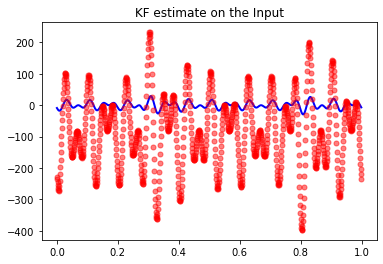

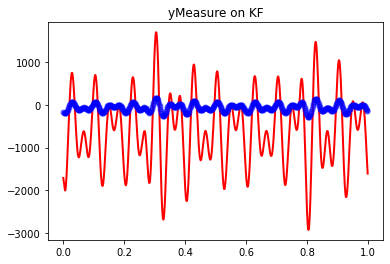

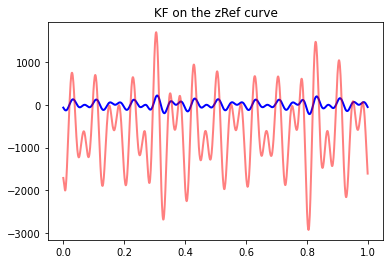

In [89]:
# plt.figure()
# plt.plot(timeRange, BInput, linestyle='-', linewidth=2, label='Ref', color='blue')
# plt.plot(timeRange[::2], KF_estimate_In[::2], 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
# plt.title('KF estimate on the Input curve')

plt.figure()
plt.plot(timeRange, xData_with_noise, linestyle='-', linewidth=2, label='Ref', color='blue')
plt.plot(timeRange, KF_estimate_In, 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
plt.title('KF estimate on the Input')
plt.savefig('KF_inputUnknown_testv1.png', dpi=300)

# plt.figure()
# plt.plot(timeRange, zRef, linestyle='-', linewidth=2, label='Ref', color='blue')
# plt.plot(timeRange[::2], yData[::2], 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
# plt.title('yMeasure Future on the zRef curve')

plt.figure()
plt.plot(timeRange, KF_estimate_Measure, linestyle='-', linewidth=2, label='Ref', color='red')
plt.plot(timeRange[::2], yData[::2], 'o', markersize=5, linestyle='', label='Pred', alpha=0.5,color='blue')
plt.title('yMeasure on KF')


plt.figure()
plt.plot(timeRange, zRef, linestyle='-', linewidth=2, label='Ref', color='blue')
#plt.plot(timeRange[::2], KF_estimate_Measure[::2], '0', markersize=5, linestyle='', label='Pred', alpha=0.5,color='red')
plt.plot(timeRange, KF_estimate_Measure, linestyle='-', linewidth=2, label='KF', color='red',alpha=0.5)

plt.title('KF on the zRef curve')


In [90]:
np.savetxt('../result/Input_unknown.txt', xData_with_noise)
np.savetxt('../result/KF_track_in.txt', KF_estimate_In)
np.savetxt('../result/Measure_unknown.txt', yData)
np.savetxt('../result/KF_track_unknown_measure.txt', KF_estimate_Measure)